# Adversarial Robustness Toolkit Membership Inference Attacks

In [1]:
import os
from IPython.display import display, Image

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import tensorflow as tf

tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

### Create datasets

In [2]:
n_classes = 2
n_features = 300

# (X,y): Original distribution
X, y = make_classification(
    n_samples=1000,
    n_classes=n_classes,
    n_features=n_features,
    n_informative=n_features,
    n_redundant=0,
    n_repeated=0,
    random_state=15,
)

# (Xt, yt) is the target dataset, owned by the TRE and drawn from the (X,y) distribution
# (Xs, ys) is a shadow dataset drawn from the (X,y) distribution
Xt, Xs, yt, ys = train_test_split(X, y, test_size=0.50, random_state=15)

# (Xd, yd) is a shadow dataset, drawn from a different distribution (different seed)
Xd, yd = make_classification(
    n_samples=1000,
    n_classes=n_classes,
    n_features=n_features,
    n_informative=n_features,
    n_redundant=0,
    n_repeated=0,
    random_state=42,
)

# Split into train (member) and test (non-member) datasets
# Set shuffle to False so that Xt_membership is consistent with Xt, otherwise
# we need to stack Xt_member and Xt_nonmember again to get a consistent Xt.
Xt_member, Xt_nonmember, yt_member, yt_nonmember = train_test_split(
    Xt, yt, test_size=0.5, shuffle=False
)

# Set membership status for future tests
Xt_membership = np.vstack(
    (
        np.ones((Xt_member.shape[0], 1), np.uint8),
        np.zeros((Xt_nonmember.shape[0], 1), np.uint8),
    )
).flatten()

### Helper functions

In [3]:
def calc_precision_recall(predicted, actual, positive_value=1):
    """Calculate the precision and recall"""
    score = 0  # both predicted and actual are positive
    num_positive_predicted = 0  # predicted positive
    num_positive_actual = 0  # actual positive
    for i in range(len(predicted)):
        if predicted[i] == positive_value:
            num_positive_predicted += 1
        if actual[i] == positive_value:
            num_positive_actual += 1
        if predicted[i] == actual[i]:
            if predicted[i] == positive_value:
                score += 1
    if num_positive_predicted == 0:
        precision = 1
    else:
        precision = (
            score / num_positive_predicted
        )  # the fraction of predicted "Yes" responses that are correct
    if num_positive_actual == 0:
        recall = 1
    else:
        recall = (
            score / num_positive_actual
        )  # the fraction of "Yes" responses that are predicted correctly
    return precision, recall

### ART black-box attacks

In [4]:
from art.attacks.inference.membership_inference import (
    MembershipInferenceBlackBoxRuleBased,
    MembershipInferenceBlackBox,
)


def art_black_box_score(attack, X_train, y_train, X_test, y_test) -> None:
    """Calculate success of black-box membership inference."""
    # infer attacked feature
    inferred_train = attack.infer(X_train, y_train)
    inferred_test = attack.infer(X_test, y_test)
    # check accuracy
    train_acc = np.sum(inferred_train) / len(inferred_train)
    test_acc = 1 - (np.sum(inferred_test) / len(inferred_test))
    acc = (train_acc * len(inferred_train) + test_acc * len(inferred_test)) / (
        len(inferred_train) + len(inferred_test)
    )
    acc *= 100  # convert fraction to percentage
    print(f"Train accuracy: {train_acc}")
    print(f"Test accuracy: {test_acc}")
    print(f"For {acc:.2f}% of the data, membership status is inferred correctly.")
    print(
        calc_precision_recall(
            np.concatenate((inferred_train, inferred_test)),
            np.concatenate(
                (np.ones(len(inferred_train)), np.zeros(len(inferred_test)))
            ),
        )
    )


def art_black_box_attack_rulebased(art_classifier):
    """Executes an ART rule-based black-box attack."""
    attack = MembershipInferenceBlackBoxRuleBased(art_classifier)
    art_black_box_score(attack, Xt_member, yt_member, Xt_nonmember, yt_nonmember)


def art_black_box_attack(art_classifier):
    """Executes an ART black-box attack."""
    attack = MembershipInferenceBlackBox(art_classifier)
    attack.fit(Xt_member, yt_member, Xt_nonmember, yt_nonmember)
    art_black_box_score(attack, Xt_member, yt_member, Xt_nonmember, yt_nonmember)

## Scikit-learn classifiers

https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/estimators/classification_scikitlearn.html

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from art.estimators.classification.scikitlearn import ScikitlearnRandomForestClassifier
from art.estimators.classification.scikitlearn import ScikitlearnSVC
from art.estimators.classification.scikitlearn import ScikitlearnBaggingClassifier
from art.estimators.classification.scikitlearn import ScikitlearnDecisionTreeClassifier


models = []

model = RandomForestClassifier(bootstrap=False)
models.append((model, ScikitlearnRandomForestClassifier, "RandomForestClassifier"))

model = SVC()
models.append((model, ScikitlearnSVC, "SVC"))

model = BaggingClassifier()
models.append((model, ScikitlearnBaggingClassifier, "BaggingClassifier"))

model = DecisionTreeClassifier()
models.append((model, ScikitlearnDecisionTreeClassifier, "DecisionTreeClassifier"))


for model, wrapper, name in models:
    model.fit(Xt_member, yt_member)
    art_classifier = wrapper(model)
    print(name + " Target Model\n")
    print(f"Base model train accuracy: {model.score(Xt_member, yt_member)}")
    print(f"Base model test accuracy: {model.score(Xt_nonmember, yt_nonmember)}")
    print("ART black-box rule-based attack:")
    art_black_box_attack_rulebased(art_classifier)
    print("ART black-box attack:")
    art_black_box_attack(art_classifier)
    print("**************************************************************")

/home/r2-preen/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


RandomForestClassifier Target Model

Base model train accuracy: 1.0
Base model test accuracy: 0.664
ART black-box rule-based attack:
Train accuracy: 1.0
Test accuracy: 0.33599999999999997
For 66.80% of the data, membership status is inferred correctly.
(0.6009615384615384, 1.0)
ART black-box attack:
Train accuracy: 1.0
Test accuracy: 1.0
For 100.00% of the data, membership status is inferred correctly.
(1.0, 1.0)
**************************************************************
SVC Target Model

Base model train accuracy: 1.0
Base model test accuracy: 0.736
ART black-box rule-based attack:
Train accuracy: 1.0
Test accuracy: 0.264
For 63.20% of the data, membership status is inferred correctly.
(0.576036866359447, 1.0)
ART black-box attack:
Train accuracy: 0.468
Test accuracy: 0.6599999999999999
For 56.40% of the data, membership status is inferred correctly.
(0.5792079207920792, 0.468)
**************************************************************


/home/r2-preen/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


BaggingClassifier Target Model

Base model train accuracy: 0.988
Base model test accuracy: 0.552
ART black-box rule-based attack:
Train accuracy: 0.988
Test accuracy: 0.44799999999999995
For 71.80% of the data, membership status is inferred correctly.
(0.6415584415584416, 0.988)
ART black-box attack:
Train accuracy: 0.712
Test accuracy: 0.888
For 80.00% of the data, membership status is inferred correctly.
(0.8640776699029126, 0.712)
**************************************************************
DecisionTreeClassifier Target Model

Base model train accuracy: 1.0
Base model test accuracy: 0.48
ART black-box rule-based attack:
Train accuracy: 1.0
Test accuracy: 0.52
For 76.00% of the data, membership status is inferred correctly.
(0.6756756756756757, 1.0)
ART black-box attack:


/home/r2-preen/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_features_` is deprecated in 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


Train accuracy: 0.532
Test accuracy: 0.5
For 51.60% of the data, membership status is inferred correctly.
(0.5155038759689923, 0.532)
**************************************************************


## Keras classifiers

Train on 250 samples, validate on 250 samples
Epoch 1/10
 32/250 [==>...........................] - ETA: 0s - loss: 3.7938 - accuracy: 0.5938WARNING:tensorflow:From /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
250/250 [==============================] - 0s 299us/sample - loss: 2.7171 - accuracy: 0.5560 - val_loss: 2.0938 - val_accuracy: 0.5600
Epoch 2/10
250/250 [==============================] - 0s 158us/sample - loss: 0.7324 - accuracy: 0.7800 - val_loss: 1.6441 - val_accuracy: 0.5880
Epoch 3/10
250/250 [==============================] - 0s 175us/sample - loss: 0.2099 - accuracy: 0.9320 - val_loss: 1.5491 - val_accuracy: 0.6120
Epoch 4/10
250/250 [==============================] - 0s 173us/sample - loss: 

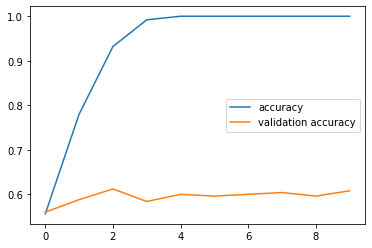

In [6]:
# Define target model
# Tensorflow model (MLP) (making it big to make it overfit)
input_data = Input(shape=n_features)
x = Dense(128, activation="relu")(input_data)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
output = Dense(n_classes, activation="softmax")(x)
target_model = Model(input_data, output)
target_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

# One-hot encoding of the labels
yt = np.eye(n_classes)[yt]
yt_member = np.eye(n_classes)[yt_member]
yt_nonmember = np.eye(n_classes)[yt_nonmember]

# ys = np.eye(n_classes)[ys]
# ys_member = np.eye(n_classes)[ys_member]
# ys_nonmember = np.eye(n_classes)[ys_nonmember]

# yd = np.eye(n_classes)[yd]
# yd_member = np.eye(n_classes)[yd_member]
# yd_nonmember = np.eye(n_classes)[yd_nonmember]


# Train target model
r = target_model.fit(
    Xt_member,
    yt_member,
    validation_data=(Xt_nonmember, yt_nonmember),
    epochs=10,
    batch_size=32,
)

plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="validation accuracy")
plt.legend()
plt.show()

### Rule-based attack on keras neural network

In [7]:
from art.estimators.classification import KerasClassifier

art_classifier = KerasClassifier(target_model)

art_black_box_attack_rulebased(art_classifier)

Train accuracy: 1.0
Test accuracy: 0.392
For 69.60% of the data, membership status is inferred correctly.
(0.6218905472636815, 1.0)


### Black-box attack on keras neural network

In [8]:
art_black_box_attack(art_classifier)

Train accuracy: 1.0
Test accuracy: 0.46799999999999997
For 73.40% of the data, membership status is inferred correctly.
(0.6527415143603134, 1.0)
